In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import batman
import lightkurve
from lightkurve import KeplerTargetPixelFile
from lightkurve.lightcurve import LightCurve
import astropy.io.fits as fits
from astropy.io import ascii
from scipy import interpolate
import math
import scipy.special

In [2]:
desktop = '/Users/willwaalkes/Desktop/'

def BATMAN_MODEL(Baseline, Rp, t = None):
    #Next we create a TransitParams object to store the physical parameters describing the transit:

    params = batman.TransitParams()
    params.t0 = 0.                       #time of inferior conjunction
    params.per = 39.09432                #period in hours
    params.rp = Rp                       #planet radius (in units of stellar radii)
    params.a = 16.                       #semi-major axis (in units of stellar radii)
    params.inc = 90.                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1956, 0.3700]          #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model
        
    m = batman.TransitModel(params, t)    #initializes model
    
    flux = m.light_curve(params)*Baseline        #calculates light curve
    return flux 

highres_times = np.linspace(-18, 2.5, 500)

In [3]:
data_v1_blue = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/erg_visit1_blue.txt')
data_v2_blue = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/erg_visit2_blue.txt')
data_v1_red = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/erg_visit1_red.txt')
data_v2_red = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/erg_visit2_red.txt')

In [4]:
alldata = {}
alldata['V1 Blue'] = data_v1_blue['Flux'],data_v1_blue['Error'],data_v1_blue['Time_hr']
alldata['V1 Red'] = data_v1_red['Flux'],data_v1_red['Error'],data_v1_red['Time_hr']
alldata['V2 Blue'] = data_v2_blue['Flux'],data_v2_blue['Error'],data_v2_blue['Time_hr']
alldata['V2 Red'] = data_v2_red['Flux'],data_v2_red['Error'],data_v2_red['Time_hr']

In [16]:
mean_flux = np.mean(data_v2_red['Flux'][0:20])
in_trans = np.mean(data_v2_red['Flux'][20:24])
relative = in_trans/mean_flux
in_trans_err = np.mean(data_v2_red['Error'][20:24])
oot_err = np.sqrt(1/(np.sum(1/(data_v2_red['Error'][0:20])**2.0)))
sigma_r = np.sqrt((in_trans_err/in_trans)**2.0+(oot_err/mean_flux)**2.0)
print(relative)
print(sigma_r)

0.9703084529064446
0.13077922166241326


In [12]:
print(len(data_v2_red['Flux']))

28


In [10]:
Posteriors = {}
Posterior_bins = {}

In [11]:
def run_emcee(event,Model=True,Plot=True):
    
    if Model:
        # intialize some walkers
        ndim, nwalkers, nsteps = 3, 100, 10000
        burnin = int(0.3*nsteps)

        # these are initial parameters
        Base1_initial = np.random.uniform(0, 1, nwalkers)
        Base2_initial = np.random.uniform(0, 1, nwalkers)
        Rp_initial = np.random.uniform(0.1, 0.5, nwalkers)

        p0 = np.transpose([Base1_initial, Base2_initial, Rp_initial])
    
        #create a sampler and run it
        
        print("Now running emcee with Gaussian lnprob")
        sampler_gauss = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gauss)
        result_gauss = sampler_gauss.run_mcmc(p0, nsteps)
    
        Base1_gauss, Base2_gauss, Rp_gauss = sampler_gauss.chain.T[:, burnin:nsteps, :]

        sig1_Rp_gauss = np.percentile(Rp_gauss, [16., 50., 84.])
        print(sig1_Rp_gauss)
        sig1_Base1_gauss = np.percentile(Base1_gauss, [16., 50., 84.])
        print(sig1_Base1_gauss)
        sig1_Base2_gauss = np.percentile(Base2_gauss, [16., 50., 84.])
        print(sig1_Base2_gauss)

        lnprob_gauss(parameters=[sig1_Base1_gauss[1],sig1_Base2_gauss[1],
                                 sig1_Rp_gauss[1]],plot=True)
        gauss_rp_hist,gauss_bins = np.histogram(Rp_gauss,bins=60,normed=True)
    
    if Plot:
        "Plot the distributions"
        plt.figure()
        plt.plot(gauss_bins[:-1],gauss_rp_hist,label='Gaussian PDF')
        plt.title('Rp/R* Distributions')
        plt.legend(frameon=False)
        plt.xlabel('Rp/R*')
        plt.ylabel('Posterior Distrubtions')
        plt.savefig('{}_RP_Posteriors.pdf'.format(event))
        plt.show()
    
    Posterior_bins['{} gauss'.format(event)] = gauss_bins
    Posteriors['{} gauss'.format(event)] = gauss_rp_hist

In [34]:
def lnprob_gauss(parameters, plot=False):
    
    event1 = 'V1 Red'
    event2 = 'V2 Red'
        
    times = highres_times
    
    flux1,error1,data_times1 = alldata[event1]
    flux2,error2,data_times2 = alldata[event2]
        
    # pull out some model parameters
    Baseline1, Baseline2, Rp = parameters
    
    model1 = BATMAN_MODEL(Baseline1, Rp, t = data_times1)
    model2 = BATMAN_MODEL(Baseline2, Rp, t = data_times2)
    
    flux_to_plot1 = BATMAN_MODEL(Baseline1, Rp, t = times)
    flux_to_plot2 = BATMAN_MODEL(Baseline2, Rp, t = times)
    
    data1 = flux1
    data2 = flux2
                            
    if plot:
        plt.errorbar(data_times1,data1,yerr=error1,fmt='o',alpha = 0.5,label='V1')
        plt.plot(times,flux_to_plot1,label='Rp/R* = {a:.2f}'.format(a=Rp),color='k')
        
        plt.errorbar(data_times2,data2,yerr=error2,fmt='o',alpha = 0.5,label='V2')
        plt.plot(times,flux_to_plot2,label='Rp/R* = {a:.2f}'.format(a=Rp),color='k')
        
        plt.legend(frameon=False)
        plt.xlabel('Time (hr from mid transit)')
        plt.ylabel('Flux')
        plt.show()

    if (0.0 < Baseline1) and (0.0 <= Rp < 1.5) and (0.0 < Baseline2):
        
        lnp1 = np.sum(-(1/2)*(data1-model1)**2.0/(error1)**2.0)
        lnp2 = np.sum(-(1/2)*(data2-model2)**2.0/(error2)**2.0)
        
        return lnp1 + lnp2
    
        if (lnp1 == NaN):
            lnp = -np.inf
        
        if (lnp2 == NaN):
            lnp = -np.inf
    
    return -np.inf

likelihoods = {}
likelihoods['gauss'] = lnprob_gauss

Now running emcee with Gaussian lnprob
[0.06477421 0.17618452 0.27870223]
[0.84254716 0.86813167 0.89382708]
[1.14336449 1.17219806 1.20092991]


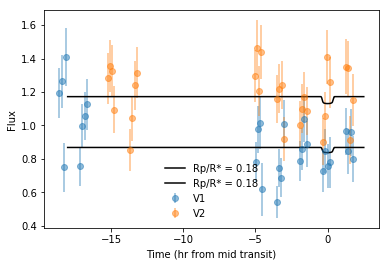

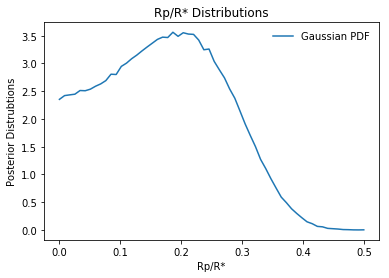

In [35]:
run_emcee(event='Red')

In [28]:
def joint_dist(shift,pdf):
    """Create a normalized joint posterior for both events"""
    
    bins = Posterior_bins['{a} {b}'.format(a=shift,b=pdf)]
    rp_hist = Posteriors['{a} {b}'.format(a=shift,b=pdf)] 
    
    CDF = np.cumsum(rp_hist)
    CDF = CDF/np.max(CDF)
    for i in range(len(CDF)):
        if (CDF[i] >= 0.95):
            twosig = i
            break

    plt.figure()
    plt.plot(bins[:-1],rp_hist,color='red')
    
    plt.axvline(bins[twosig],color='gray',linestyle='-',
                label='Red 2-$\sigma$ Rp ={:.2f}'.format(bins[twosig]))
    
    shift='Blue'
    pdf='gauss'

    bins = Posterior_bins['{a} {b}'.format(a=shift,b=pdf)]
    rp_hist = Posteriors['{a} {b}'.format(a=shift,b=pdf)]
    
    CDF = np.cumsum(rp_hist) 
    CDF = CDF/np.max(CDF)
    for i in range(len(CDF)):
        if (CDF[i] >= 0.95):
            twosig = i
            break

    plt.plot(bins[:-1],rp_hist,color='blue')
    plt.axvline(bins[twosig],color='gray',linestyle='--',
                label='Blue 2-$\sigma$ Rp ={:.2f}'.format(bins[twosig]))
    plt.title('Joint Rp/R* Posterior with Gaussian Likelihood')
    plt.xlabel('Rp/R*')
    plt.ylabel('Normalized Distrubtion')
    plt.legend()
    plt.tight_layout()
    plt.savefig('Blue_Red_Joint_Rp_Posterior.pdf')
    plt.show()

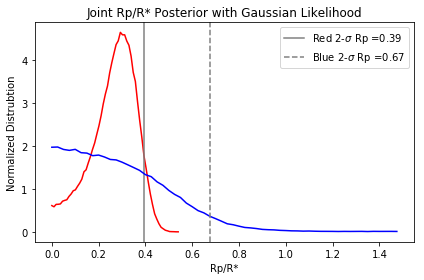

In [29]:
joint_dist(shift='Red',pdf='gauss')